#Library

In [ ]:
import zipfile, os, time, warnings
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import drive
import matplotlib.pyplot as plt

from sklearn.preprocessing import  OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedStratifiedKFold, cross_validate, cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import plot_confusion_matrix

warnings.filterwarnings('ignore')

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Data Understanding

##Data Loading

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"

In [ ]:
%cd /content/drive/MyDrive/Kaggle

/content/drive/MyDrive/Kaggle


In [ ]:
!kaggle datasets download -d fedesoriano/stroke-prediction-dataset

  0% 0.00/67.4k [00:00<?, ?B/s]
100% 67.4k/67.4k [00:00<00:00, 5.90MB/s]


In [ ]:
!unzip \stroke-prediction-dataset.zip && rm *.zip

Archive:  stroke-prediction-dataset.zip
  inflating: healthcare-dataset-stroke-data.csv  


In [ ]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


##Exploratory Data Analysis

###Descriptive analysis

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


dalam datset stroke terdapat 7 data numeric dan 4 data categorical

In [ ]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


###Missing Value

Pada analsisi deskriptif ternyata diketahui bahwa kolom bmi memiliki data yang hilang

In [ ]:
bmi_missing = df['bmi'].isna().sum()
print("Nilai 0 di kolom bmi ada: ", bmi_missing)

Nilai 0 di kolom bmi ada:  201


Karena data yang kosong cukup banyak maka akan dilakukan pengisian untuk data yang kosong, sebelum itu harus diketahui apakah data bmi memiliki outlier atau tidak.

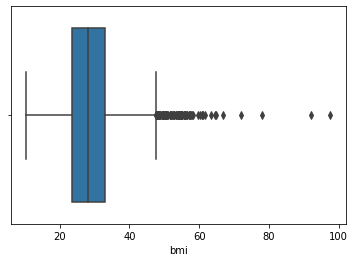

In [ ]:
sns.boxplot(x=df['bmi'])

ternyata data memiliki outliers maka data yang kosong akan diisi dengan median

In [ ]:
df['bmi'].fillna(df['bmi'].median(), inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                5110 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


###Univariate Analysis

Menghapus kolom id karena tidak diperlukan

In [ ]:
df.drop('id', axis=1, inplace=True)

In [ ]:
numerical_features = ['age', 'avg_glucose_level', 'bmi']
categorical_features = ['gender', 'ever_married', 'work_type','Residence_type','smoking_status', 'hypertension', 'heart_disease', 'stroke']

####Categorical Feature

In [ ]:
def cat_viz(feature):
  count = df[feature].value_counts()
  percent = 100*df[feature].value_counts(normalize=True)
  temp = pd.DataFrame({'jumlah sampel':count, 'persentase':percent.round(1)})
  print(temp)
  count.plot(kind='bar', title=feature);

        jumlah sampel  persentase
Female           2994        58.6
Male             2115        41.4
Other               1         0.0


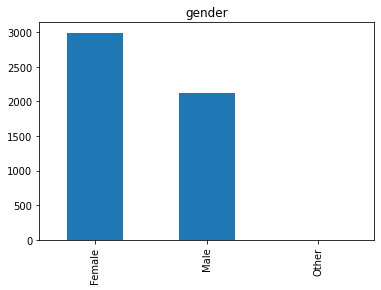

In [ ]:
cat_viz(categorical_features[0])

Dari sample data yang diambil ternyata dominan dengan jenis kelamin perempuan

     jumlah sampel  persentase
Yes           3353        65.6
No            1757        34.4


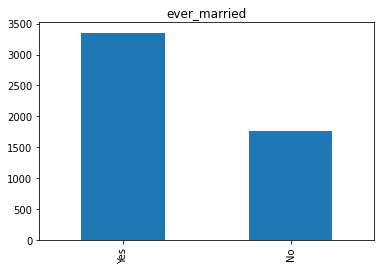

In [ ]:
cat_viz(categorical_features[1])

Dari sample data yang diambil ternyata lebih dominan pernah menikah

               jumlah sampel  persentase
Private                 2925        57.2
Self-employed            819        16.0
children                 687        13.4
Govt_job                 657        12.9
Never_worked              22         0.4


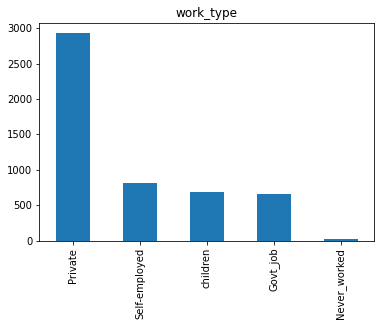

In [ ]:
cat_viz(categorical_features[2])

       jumlah sampel  persentase
Urban           2596        50.8
Rural           2514        49.2


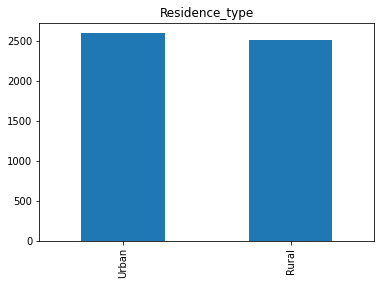

In [ ]:
cat_viz(categorical_features[3])

                 jumlah sampel  persentase
never smoked              1892        37.0
Unknown                   1544        30.2
formerly smoked            885        17.3
smokes                     789        15.4


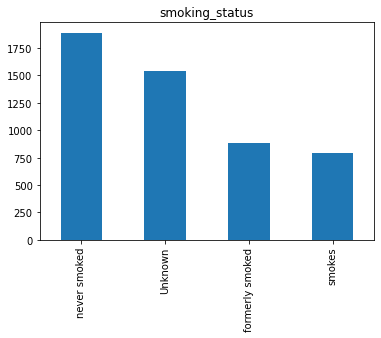

In [ ]:
cat_viz(categorical_features[4])

Data didominasi oleh orang yang tidak pernah merokok 

   jumlah sampel  persentase
0           4612        90.3
1            498         9.7


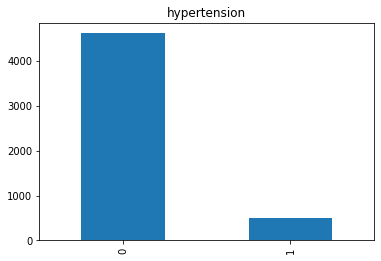

In [ ]:
cat_viz(categorical_features[5])

   jumlah sampel  persentase
0           4834        94.6
1            276         5.4


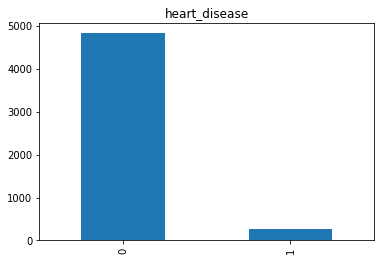

In [ ]:
cat_viz(categorical_features[6])

   jumlah sampel  persentase
0           4861        95.1
1            249         4.9


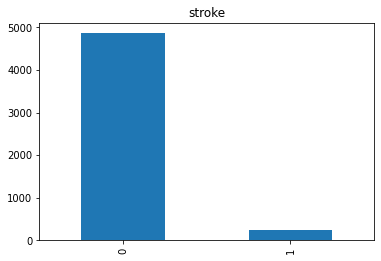

In [ ]:
cat_viz(categorical_features[7])

Ternyata class prediksi sangat tidak seimbang, sehingga nantinya perlu dilakukan data balancing

####Numerical Feature

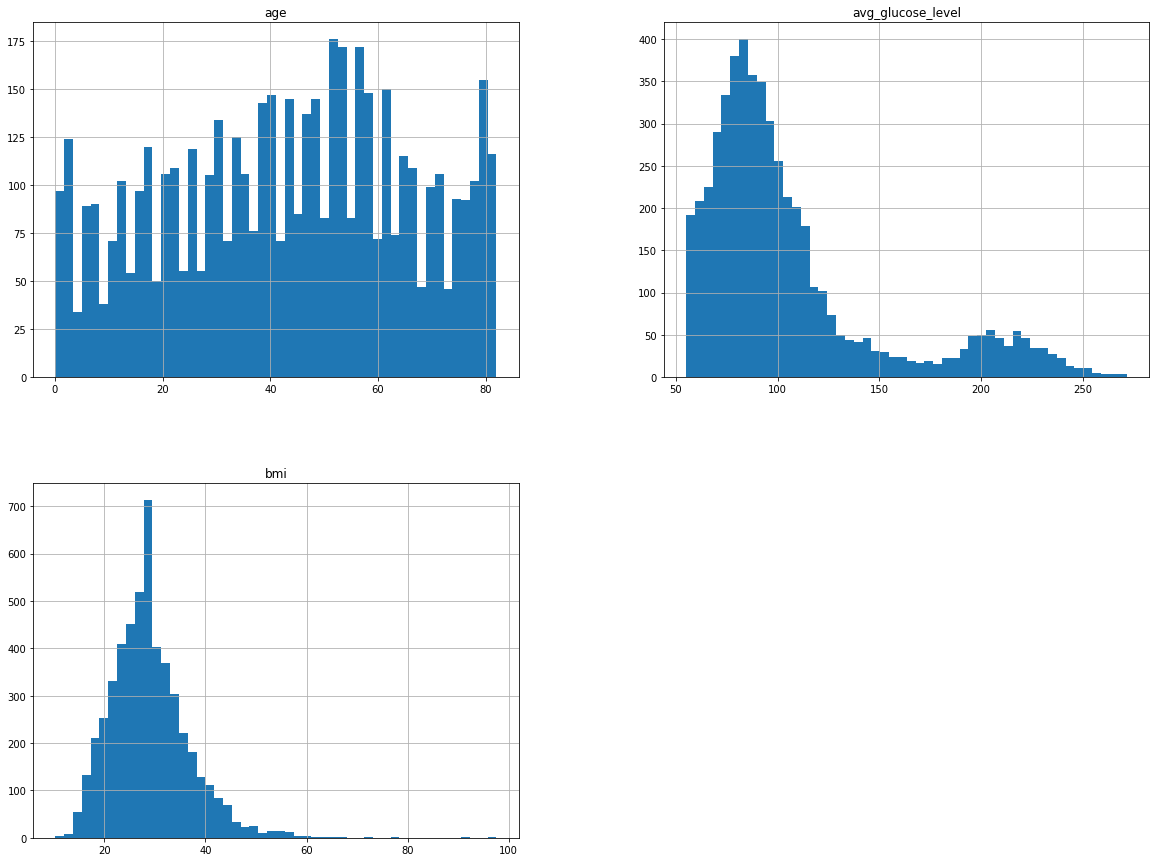

In [ ]:
df[numerical_features].hist(bins=50, figsize=(20,15))
plt.show()

###Multivariate Analysis

Text(0.5, 1.0, 'Correlation Matrix untuk Fitur Numerik ')

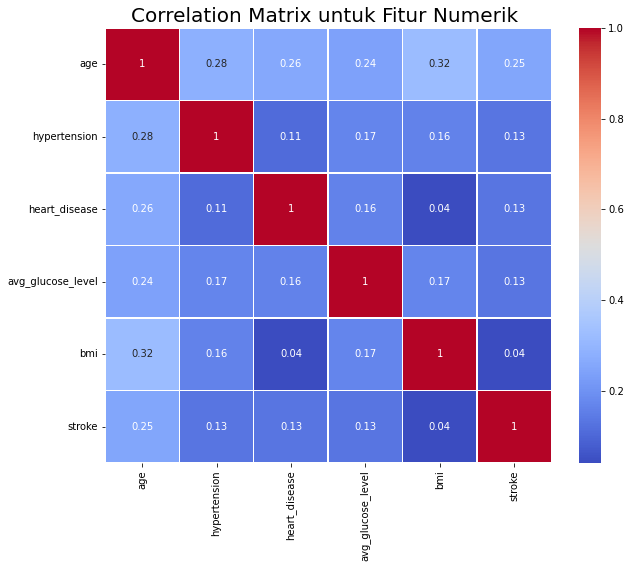

In [ ]:
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, )
plt.title("Correlation Matrix untuk Fitur Numerik ", size=20)

Dari korelasi diketahui bahwa stroke memiliki nilai korelasi positif dengan umur yang paling tinggi kemudian diikuti oleh darah tinggi, penyakit jantung dan rata rata level glukosa

#Data Preparation

##Feature Encoding

In [ ]:
for cat in categorical_features[:5]:
  df = pd.concat([df, pd.get_dummies(df[cat], prefix=cat)],axis=1)
  df.drop([cat], axis=1, inplace=True)

In [ ]:
df

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,ever_married_No,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,0,1,0,0,...,0,1,0,0,0,1,0,1,0,0
1,61.0,0,0,202.21,28.1,1,1,0,0,0,...,0,0,1,0,1,0,0,0,1,0
2,80.0,0,1,105.92,32.5,1,0,1,0,0,...,0,1,0,0,1,0,0,0,1,0
3,49.0,0,0,171.23,34.4,1,1,0,0,0,...,0,1,0,0,0,1,0,0,0,1
4,79.0,1,0,174.12,24.0,1,1,0,0,0,...,0,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,80.0,1,0,83.75,28.1,0,1,0,0,0,...,0,1,0,0,0,1,0,0,1,0
5106,81.0,0,0,125.20,40.0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,1,0
5107,35.0,0,0,82.99,30.6,0,1,0,0,0,...,0,0,1,0,1,0,0,0,1,0
5108,51.0,0,0,166.29,25.6,0,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0


Text(0.5, 1.0, 'Correlation Matrix')

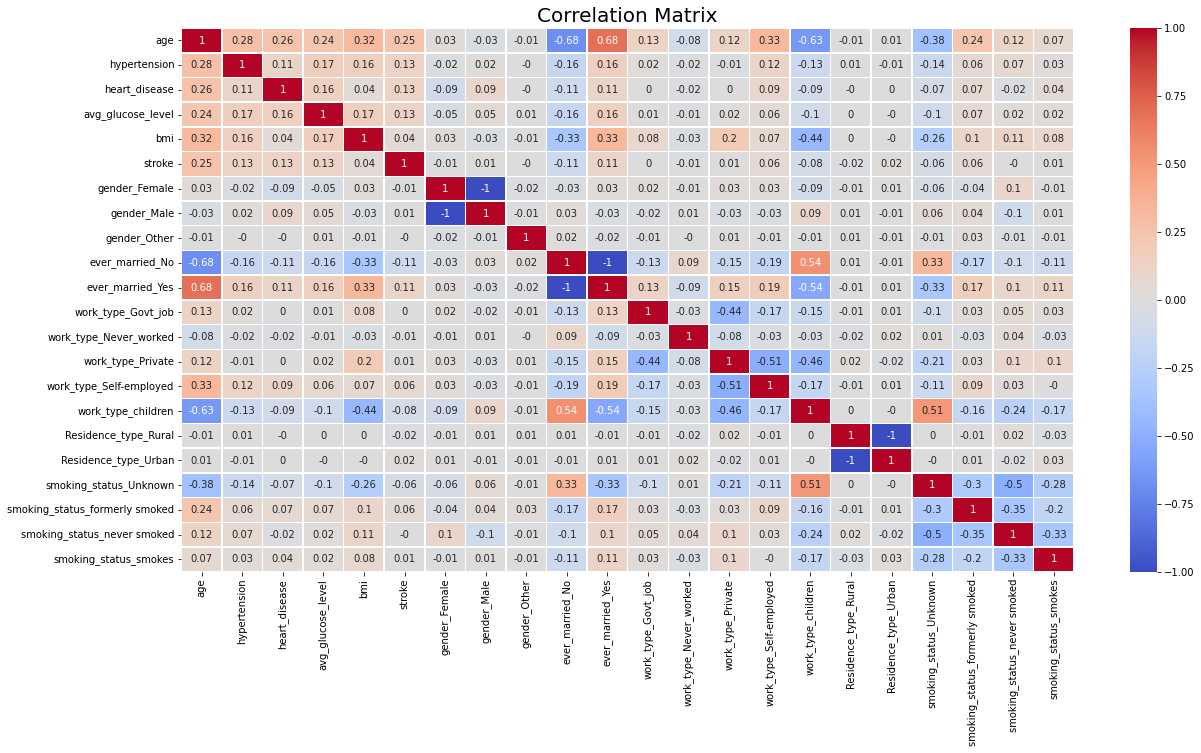

In [ ]:
plt.figure(figsize=(20, 10))
correlation_matrix = df.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, )
plt.title("Correlation Matrix", size=20)

Ternyata setelah dicek lagi kolom age, hypertension, heart_disease, dan avg_glucose_level lah yang mempunyai korelasi besar dengan kolom stroke sehingga kolom tersebut yang akan digunakan sebagai fitur untuk train

##Data Balancing

In [ ]:
x = df[['age','hypertension','heart_disease','avg_glucose_level']]
y = df['stroke']

Karena pada tahap sebelumnya diketahui bahwa klass prediksi tidak seimbang maka akan dilakukan SMOTE untuk upscale data minoritas

In [ ]:
oversample = SMOTE()
X, Y = oversample.fit_resample(x,y)

In [ ]:
Y.value_counts()

1    4861
0    4861
Name: stroke, dtype: int64

##Split Data

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 123)

##Scaling Data

In [ ]:
scaling_feature = ['age','avg_glucose_level']
scaler = StandardScaler()
scaler.fit(X_train[scaling_feature])
X_train[scaling_feature] = scaler.transform(X_train.loc[:, scaling_feature])
X_test[scaling_feature] = scaler.transform(X_test.loc[:, scaling_feature])

In [ ]:
X_train.head()

,age,hypertension,heart_disease,avg_glucose_level
8746,0.235453,0,0,-0.801158
3354,-1.572725,0,0,-0.068230
384,-2.291621,0,0,-0.167706
4698,-0.539312,0,0,-0.933525
6114,-0.591521,0,0,-0.648011


In [ ]:
X_test.head()

,age,hypertension,heart_disease,avg_glucose_level
6633,-0.355883,0,0,1.840914
641,-1.797380,0,0,-0.618219
7785,-0.322689,0,0,-0.624866
988,-1.572725,0,0,-0.344033
4796,0.808619,1,0,-0.865472


#Model Development

In [ ]:
model_performance = pd.DataFrame(columns=['Accuracy','Recall','Precision','F1-Score','time to train','time to predict','total time'])

##Base Model

Decision Tree

In [ ]:
model_1 = DecisionTreeClassifier()
start = time.time()
model_1.fit(X_train, Y_train)
end_train = time.time()
y_pred_1 = model_1.predict(X_test)
end_predict = time.time()

In [ ]:
accuracy = accuracy_score(Y_test, y_pred_1)
recall = recall_score(Y_test, y_pred_1, average='weighted')
precision = precision_score(Y_test, y_pred_1, average='weighted')
f1s = f1_score(Y_test, y_pred_1, average='weighted')

print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("time to train: "+ "{:.2f}".format(end_train-start)+" s")
print("time to predict: "+"{:.2f}".format(end_predict-end_train)+" s")
print("total: "+"{:.2f}".format(end_predict-start)+" s")
model_performance.loc['DT'] = [accuracy, recall, precision, f1s,end_train-start,end_predict-end_train,end_predict-start]

Accuracy: 89.92%
Recall: 89.92%
Precision: 89.92%
F1-Score: 89.92%
time to train: 0.03 s
time to predict: 0.00 s
total: 0.03 s


K-Nearest Neighbour

In [ ]:
model_2=KNeighborsClassifier()
start = time.time()
model_2.fit(X_train, Y_train)
end_train = time.time()
y_pred_2 = model_2.predict(X_test)
end_predict = time.time()

In [ ]:
accuracy = accuracy_score(Y_test, y_pred_2)
recall = recall_score(Y_test, y_pred_2, average='weighted')
precision = precision_score(Y_test, y_pred_2, average='weighted')
f1s = f1_score(Y_test, y_pred_2, average='weighted')

print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("time to train: "+ "{:.2f}".format(end_train-start)+" s")
print("time to predict: "+"{:.2f}".format(end_predict-end_train)+" s")
print("total: "+"{:.2f}".format(end_predict-start)+" s")
model_performance.loc['KNN'] = [accuracy, recall, precision, f1s,end_train-start,end_predict-end_train,end_predict-start]

Accuracy: 85.86%
Recall: 85.86%
Precision: 86.54%
F1-Score: 85.79%
time to train: 0.01 s
time to predict: 0.06 s
total: 0.07 s


Naive Bayes

In [ ]:
model_3 = GaussianNB()
start = time.time()
model_3.fit(X_train, Y_train)
end_train = time.time()
y_pred_3 = model_3.predict(X_test)
end_predict = time.time()

In [ ]:
accuracy = accuracy_score(Y_test, y_pred_3)
recall = recall_score(Y_test, y_pred_3, average='weighted')
precision = precision_score(Y_test, y_pred_3, average='weighted')
f1s = f1_score(Y_test, y_pred_3, average='weighted')

print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("time to train: "+ "{:.2f}".format(end_train-start)+" s")
print("time to predict: "+"{:.2f}".format(end_predict-end_train)+" s")
print("total: "+"{:.2f}".format(end_predict-start)+" s")
model_performance.loc['NB'] = [accuracy, recall, precision, f1s,end_train-start,end_predict-end_train,end_predict-start]

Accuracy: 74.86%
Recall: 74.86%
Precision: 75.20%
F1-Score: 74.76%
time to train: 0.01 s
time to predict: 0.00 s
total: 0.01 s


Logistic Regression

In [ ]:
model_4 = LogisticRegression()
start = time.time()
model_4.fit(X_train,Y_train)
end_train = time.time()
y_pred_4 = model_4.predict(X_test)
end_predict = time.time()

In [ ]:
accuracy = accuracy_score(Y_test, y_pred_4)
recall = recall_score(Y_test, y_pred_4, average='weighted')
precision = precision_score(Y_test, y_pred_4, average='weighted')
f1s = f1_score(Y_test, y_pred_4, average='weighted')

print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("time to train: "+ "{:.2f}".format(end_train-start)+" s")
print("time to predict: "+"{:.2f}".format(end_predict-end_train)+" s")
print("total: "+"{:.2f}".format(end_predict-start)+" s")
model_performance.loc['LR'] = [accuracy, recall, precision, f1s,end_train-start,end_predict-end_train,end_predict-start]

Accuracy: 76.66%
Recall: 76.66%
Precision: 76.73%
F1-Score: 76.64%
time to train: 0.03 s
time to predict: 0.00 s
total: 0.03 s


Random Forest

In [ ]:
model_5 = RandomForestClassifier()
start = time.time()
model_5.fit(X_train,Y_train)
end_train = time.time()
y_pred_5 = model_5.predict(X_test)
end_predict = time.time()

In [ ]:
accuracy = accuracy_score(Y_test, y_pred_5)
recall = recall_score(Y_test, y_pred_5, average='weighted')
precision = precision_score(Y_test, y_pred_5, average='weighted')
f1s = f1_score(Y_test, y_pred_5, average='weighted')

print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("time to train: "+ "{:.2f}".format(end_train-start)+" s")
print("time to predict: "+"{:.2f}".format(end_predict-end_train)+" s")
print("total: "+"{:.2f}".format(end_predict-start)+" s")
model_performance.loc['RF'] = [accuracy, recall, precision, f1s,end_train-start,end_predict-end_train,end_predict-start]

Accuracy: 91.88%
Recall: 91.88%
Precision: 91.88%
F1-Score: 91.88%
time to train: 0.76 s
time to predict: 0.05 s
total: 0.81 s


Cek Model yang bagus untuk dilakukan Hyper Parameter Tuning

In [ ]:
model_performance.fillna(.90,inplace=True)
model_performance.style.background_gradient(cmap='coolwarm').format({'Accuracy': '{:.2%}',
                                                                     'Precision': '{:.2%}',
                                                                     'Recall': '{:.2%}',
                                                                     'F1-Score': '{:.2%}',
                                                                     'time to train':'{:.1f}',
                                                                     'time to predict':'{:.1f}',
                                                                     'total time':'{:.1f}',
                                                                     })

,Accuracy,Recall,Precision,F1-Score,time to train,time to predict,total time
DT,89.92%,89.92%,89.92%,89.92%,0.0,0.0,0.0
KNN,85.86%,85.86%,86.54%,85.79%,0.0,0.1,0.1
NB,74.86%,74.86%,75.20%,74.76%,0.0,0.0,0.0
LR,76.66%,76.66%,76.73%,76.64%,0.0,0.0,0.0
RF,91.88%,91.88%,91.88%,91.88%,0.8,0.0,0.8


##Hyper Parameter Tuning

In [ ]:
cv_method = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

Random Forest

In [ ]:
param_grid_rf = {'n_estimators':np.arange(50,150,5),'criterion':['gini','entropy']}
model_5_hpt = GridSearchCV(RandomForestClassifier(), param_grid=param_grid_rf, cv=cv_method ,scoring='accuracy')
start = time.time()
model_5_hpt.fit(X_train,Y_train)
end_train = time.time()
y_pred_5_hpt = model_5_hpt.predict(X_test)
end_predict = time.time()

In [ ]:
accuracy = accuracy_score(Y_test, y_pred_5_hpt)
recall = recall_score(Y_test, y_pred_5_hpt, average='weighted')
precision = precision_score(Y_test, y_pred_5_hpt, average='weighted')
f1s = f1_score(Y_test, y_pred_5_hpt, average='weighted')
print("Best Parameters:",model_5_hpt.best_params_)
print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("time to train: "+ "{:.2f}".format(end_train-start)+" s")
print("time to predict: "+"{:.2f}".format(end_predict-end_train)+" s")
print("total: "+"{:.2f}".format(end_predict-start)+" s")
model_performance.loc['RF_HPT'] = [accuracy, recall, precision, f1s,end_train-start,end_predict-end_train,end_predict-start]

Best Parameters: {'criterion': 'entropy', 'n_estimators': 130}
Accuracy: 92.44%
Recall: 92.44%
Precision: 92.45%
F1-Score: 92.44%
time to train: 1561.49 s
time to predict: 0.05 s
total: 1561.54 s


#Model Evaluation

In [ ]:
model_performance.fillna(.90,inplace=True)
model_performance.style.background_gradient(cmap='coolwarm').format({'Accuracy': '{:.2%}',
                                                                     'Precision': '{:.2%}',
                                                                     'Recall': '{:.2%}',
                                                                     'F1-Score': '{:.2%}',
                                                                     'time to train':'{:.1f}',
                                                                     'time to predict':'{:.1f}',
                                                                     'total time':'{:.1f}',
                                                                     })

,Accuracy,Recall,Precision,F1-Score,time to train,time to predict,total time
DT,89.92%,89.92%,89.92%,89.92%,0.0,0.0,0.0
KNN,85.86%,85.86%,86.54%,85.79%,0.0,0.1,0.1
NB,74.86%,74.86%,75.20%,74.76%,0.0,0.0,0.0
LR,76.66%,76.66%,76.73%,76.64%,0.0,0.0,0.0
RF,91.88%,91.88%,91.88%,91.88%,0.8,0.0,0.8
RF_HPT,92.44%,92.44%,92.45%,92.44%,1561.5,0.0,1561.5
